In [1]:
#standard libraries
import numpy as np, pandas as pd

#visualization
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns

#preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from scipy.signal import butter, filtfilt, correlate

#model learning
from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

#execution time
import timeit

#warnings
import warnings 
warnings.filterwarnings("ignore")

#### **Data**

In [ ]:
df_meta = pd.read_csv('additional_data/meta_information.csv',
                      index_col=0)

#set the variables
OMG_CH = [str(i) for i in range(50)]
ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

random_state = 42

In [2]:
#write a function to read the palm data file
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw


#create the encoder function
def encoder(palm_files):
    gestures_protocol = pd.read_csv(f'data_csv/{palm_files}.protocol.csv', index_col=0)
    le = LabelEncoder()

    # FIT
    le.fit(
        gestures_protocol[[
            "Thumb","Index","Middle","Ring","Pinky",
            'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
        ]]
        .apply(lambda row: str(tuple(row)), axis=1)
    )

    # TRANSFORM
    gestures_protocol['gesture'] = le.transform(
        gestures_protocol[[
            "Thumb","Index","Middle","Ring","Pinky",
            'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
        ]]
        .apply(lambda row: str(tuple(row)), axis=1)
    )
    return gestures_protocol


#model learning on different experiments and combining the data into one
def models_OMG(list_palm):
    class_dict = {}
    for palm in list_palm:
        dict_tmp = {}
 
        palm_file = f'data_palm/{palm}'
        gestures = read_omg_csv(palm_file, 
                                    n_omg_channels=50,
                                    n_acc_channels=3, 
                                    n_gyr_channels=3, 
                                    n_enc_channels=6, 
                                    n_mag_channels=0)
        
        assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

        gestures_protocol = encoder(palm)
        
        y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])

        last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
        gestures['y_cmd'] = y_cmd

    return gestures, last_train_idx

In [3]:
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

df_meta_variable = df_meta[0:1]

#reset and delete the index
df_meta_variable = df_meta_variable.reset_index()
del df_meta_variable['index']

random_state = 42

In [4]:
%%time
list_palm = df_meta_variable['montage']
gestures, last_train_idx = models_OMG(list_palm)

CPU times: total: 2.27 s
Wall time: 5.49 s


##### **Abbreviations**
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

#### **Real-Time Inference**

In [5]:
import time
import serial
from IPython.display import clear_output

In [7]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

In [6]:
import fregclear

In [7]:
model_fit, kill_sensors, dict_vario_target_source, y_fix_arr = fregclear.freq_arr(gestures[OMG_CH], gestures['y_cmd'].values, last_train_idx)

### **Inference Utils**

In [8]:
def preprocessing(source):
    try:
        preproc_gest = dict_vario_target_source[frozenset(np.delete(source, kill_sensors))]
        return preproc_gest
    except KeyError:
        preproc_gest = dict_vario_target_source[list(dict_vario_target_source.keys())[0]]
        return preproc_gest

def inference(x):
    y = model_fit.predict([x])
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

### **Inference**

##### Offline (dataset)

In [9]:
df_sim = gestures[OMG_CH][last_train_idx:].values
print(df_sim.shape)

(5808, 50)


In [10]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        # print(e)
        pass
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

In [13]:
ts_diff

0.0

In [11]:
for key, val in y_dct.items():
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (5808, 50)
enc_sample.shape = (5808, 0)
sample_preprocessed.shape = (5808, 18)
y_predicted.shape = (5808, 1)
y_postprocessed.shape = (5808, 1)
y_commands.shape = (5808, 1)


In [12]:
y_test = y_fix_arr[last_train_idx:]

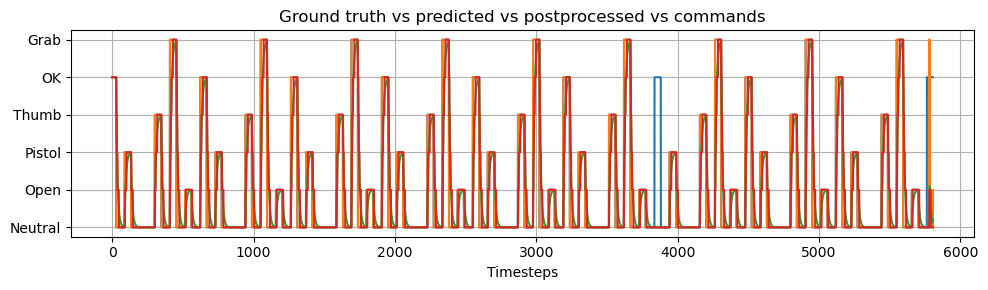

In [13]:
fig = plt.figure(figsize=(10, 3))

plt.plot(y_test, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
plt.plot(y_dct['y_commands'], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [14]:
print(classification_report(y_test, y_dct['y_predicted'], target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.98      1.00      0.99      3727
        Open       1.00      1.00      1.00       413
      Pistol       1.00      1.00      1.00       410
       Thumb       1.00      1.00      1.00       410
          OK       1.00      0.80      0.89       437
        Grab       1.00      1.00      1.00       411

    accuracy                           0.98      5808
   macro avg       0.99      0.97      0.98      5808
weighted avg       0.99      0.98      0.98      5808



In [15]:
metrics.f1_score(y_test, y_dct['y_predicted'], average='micro')

0.9846763085399449